### Imports

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import glob
import numpy as np
import os

### Helper Functions

In [3]:
def draw_matches(img1, kp1, img2, kp2, matches): 
    """
    Python implementation of draw matches to allow configuration of line width and colour
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 30
    thickness = 10
    red = (255, 0, 0)
    for m in matches:
        end1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(new_img)
    plt.show()

In [4]:
def draw_matches_manual(img1, kp1, img2, kp2): 
    """
    Python implementation of draw matches to allow drawing manual keypoint correspondences
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 30
    thickness = 10
    red = (255, 0, 0)
    for i in range(len(kp1)):
        end1 = tuple(np.round(kp1[i]).astype(int))
        end2 = tuple(np.round(kp2[i]).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(new_img)
    plt.show()

### Load Images

In [5]:
filenames = glob.glob("photos/*.jpg")
print(f"{len(filenames)} images found")
images = [cv.imread(f) for f in filenames]

27 images found


In [6]:
print(filenames[15], filenames[16])

photos\IMG_1816.HEIC.jpg photos\IMG_1817.HEIC.jpg


### Display Images

In [7]:
rows = len(images) // 5
cols = (len(images) // rows) + 1

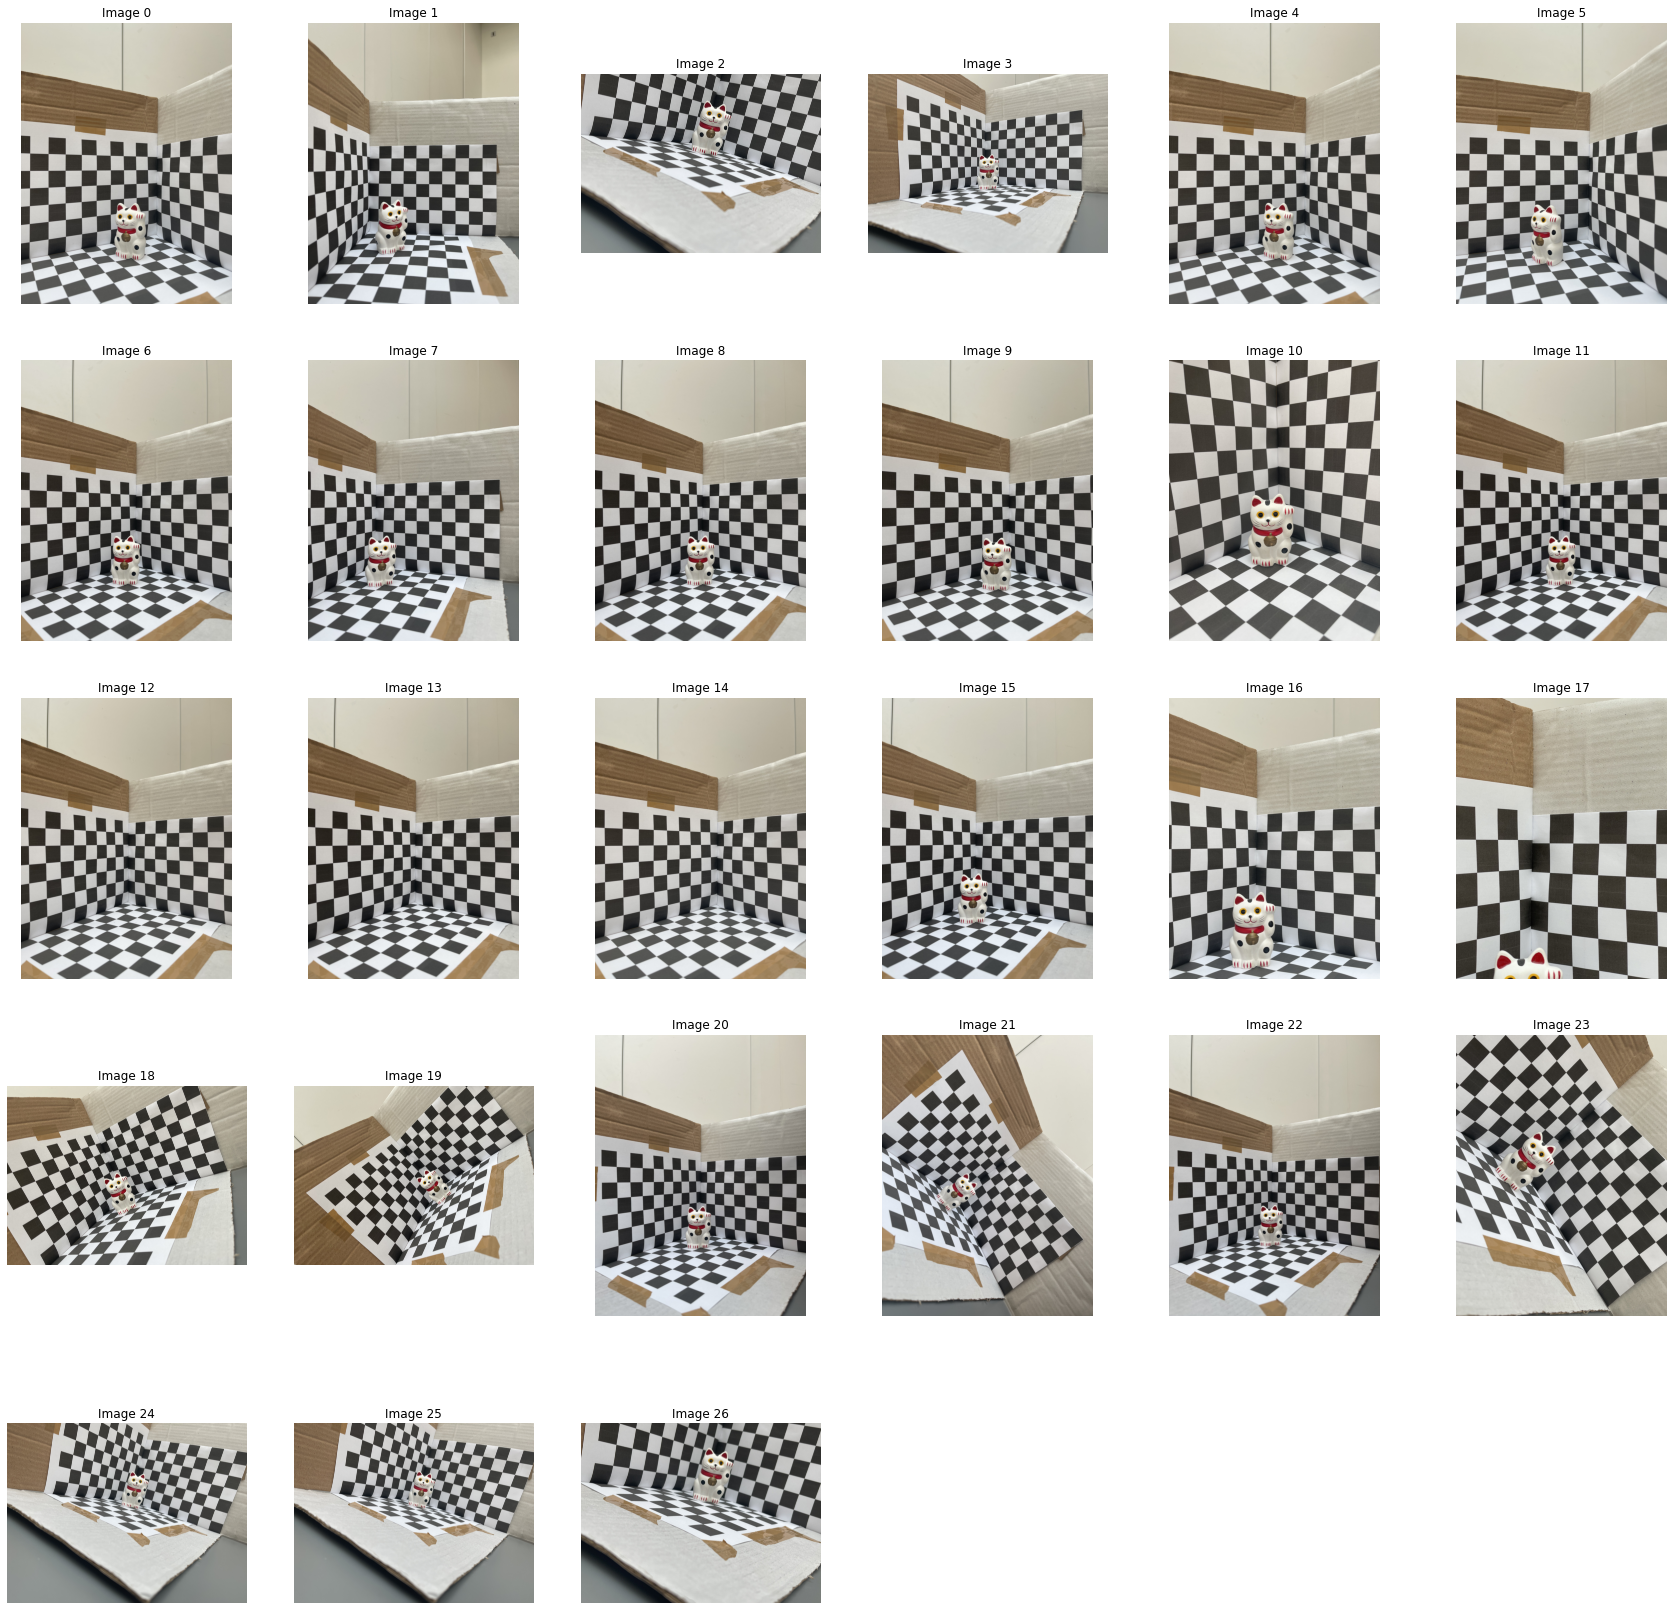

In [8]:
# This cell takes a while to run :( - consider commenting out if re-running notebook

fig = plt.figure(figsize=(30, 30))
for i in range(len(images)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i][...,::-1]) # BGR to RGB - OpenCV image to Matplotlib
    plt.axis("off")
    plt.title(f"Image {i}")

### Keypoint correspondences between images
Compare quality/quantity of correspondences found by two methods:
- Manual (clicking on corresponding points)
- Automatic (detecting keypoint and matching descriptors)

#### Manual keypoint correspondence

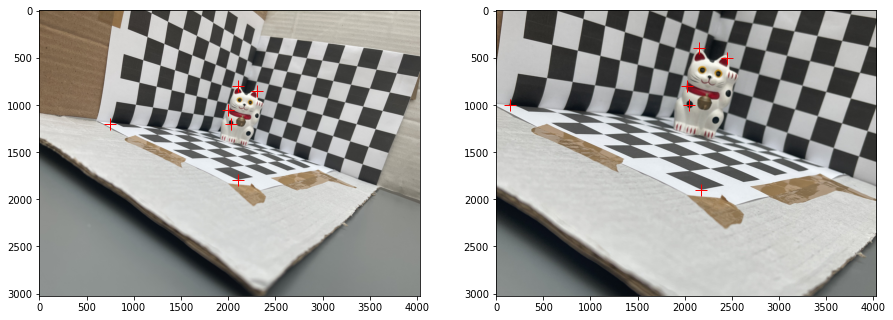

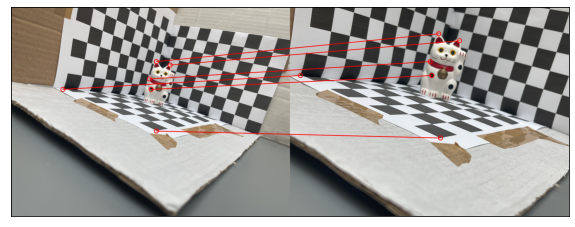

In [9]:
img1 = cv.imread(os.path.join("photos", "keypoint_correspond_1.jpg"))
img2 = cv.imread(os.path.join("photos", "keypoint_correspond_2.jpg"))

kp1 = np.array([[2000, 1050], 
                [2100, 800], 
                [2300, 850],
               [2025, 1200],
               [750, 1200], 
               [2100, 1800]])


kp2 = np.array([[2025, 800], 
                [2150, 400], 
                [2450, 500],
               [2050, 1000],
               [150, 1000], 
               [2175, 1900]])

rows, cols = 1,2
fig = plt.figure(figsize=(15,15))
fig.add_subplot(rows, cols, 1)
plt.imshow(img1[...,::-1])
for coord in kp1:
    plt.plot(coord[0], coord[1], 'r+', markersize=12)
fig.add_subplot(rows, cols, 2)
plt.imshow(img2[...,::-1])
for coord in kp2:
    plt.plot(coord[0], coord[1], 'r+', markersize=12)

draw_matches_manual(img1[...,::-1], kp1, img2[...,::-1], kp2)

In [10]:
matches_manual = np.stack([kp1, kp2], axis=-2)

#### Automatic keypoint correspondence using SIFT

In [11]:
def sift_match(img1, img2, ratio=0.3):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test: see https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
    return img1, kp1, img2, kp2, good

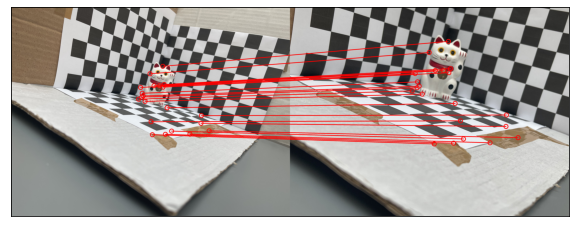

In [12]:
img1, kp1, img2, kp2, good = sift_match(img1, img2, ratio = 0.15)
draw_matches(img1[...,::-1],kp1,img2[...,::-1],kp2, good)

In [13]:
def matches_to_arr(kp1, kp2, matches):
    idxs = []
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        pair = (kp1[img1_idx].pt, kp2[img2_idx].pt)
        idxs.append(pair)
    return np.array(idxs)

rows, cols, channels = img1.shape

print("Image dims:", rows, cols, channels)

matches_sift = matches_to_arr(kp1, kp2, good)

print("Matches shape:", matches_sift.shape)

Image dims: 3024 4032 3
Matches shape: (23, 2, 2)


### Camera calibration

#### Warning: Takes time to run!

- Recommended dims for calibration: (4,4) or (5,4)
- Find and report camera parameters.
- Can you estimate or illustrate distortions of your camera?

In [69]:
def calibrateCamera(dim1=4, dim2=4):
    used_images = []
    images = glob.glob('.\catpics\*.jpg')
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((dim2*dim1,3), np.float32)
    objp[:,:2] = np.mgrid[0:dim1,0:dim2].T.reshape(-1,2)
    #objp = objp*24
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (dim1,dim2), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            used_images.append(fname)

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error
    mean_error = mean_error/len(objpoints)

    return ret, mtx, dist, rvecs, tvecs, used_images, mean_error

In [70]:
def showCalibration(path, dim1=4, dim2=4):
    imag = cv.imread(path)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((dim2*dim1,3), np.float32)
    objp[:,:2] = np.mgrid[0:dim1,0:dim2].T.reshape(-1,2)
    #objp = objp*24
    gray = cv.cvtColor(imag, cv.COLOR_BGR2GRAY)
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (dim1,dim2), None)
    if ret == True:
        print('Grid calibrated')
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(imag, (dim1,dim2), corners2, ret)
        cv.imwrite("calibrated_main.png", imag)
        imS = cv.resize(imag, (960, 960))
        cv.imshow('img', imS)
        cv.waitKey()
    else:
        print('Calibration unsuccessful')

In [71]:
#takes time to run, approx 8 min
ret, mtx, dist, rvecs, tvecs, used_images, mean_error = calibrateCamera(4, 5)

In [45]:
#takes about 20 secs
showCalibration(used_images[1], 4,5)
#showCalibration(os.path.join('catpics', ''), 4,4)
#print(used_images)

Grid calibrated


In [87]:
print(rvecs[0])
bigR = cv.Rodrigues(rvecs[0])
print(bigR[0])
print(tvecs[0])
print(ret)
print(mean_error)
print(used_images)

[[-0.86563668]
 [ 1.62795783]
 [ 1.61700712]]
[[-0.55101631 -0.83443718  0.00977852]
 [ 0.00414644  0.00898004  0.99995108]
 [-0.83448417  0.5510299  -0.0014882 ]]
[[ 2.65647657]
 [ 5.61596832]
 [15.28311408]]
5.094509157176714
1.0881457416777045
['.\\catpics\\IMG_1807.jpg', '.\\catpics\\IMG_1808.jpg', '.\\catpics\\IMG_1809.jpg', '.\\catpics\\IMG_1810.jpg', '.\\catpics\\IMG_1811.jpg', '.\\catpics\\IMG_1812.jpg', '.\\catpics\\IMG_1813.jpg', '.\\catpics\\IMG_1826.jpg', '.\\catpics\\IMG_1827.jpg', '.\\catpics\\IMG_1829.jpg', '.\\catpics\\onlyboard.jpg']


In [107]:
img = cv.imread('.\catpics\IMG_1811.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
print(newcameramtx)
print(roi)

[[3.03641357e+03 0.00000000e+00 1.91453754e+03]
 [0.00000000e+00 2.84774609e+03 1.94803235e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(301, 256, 2684, 3480)


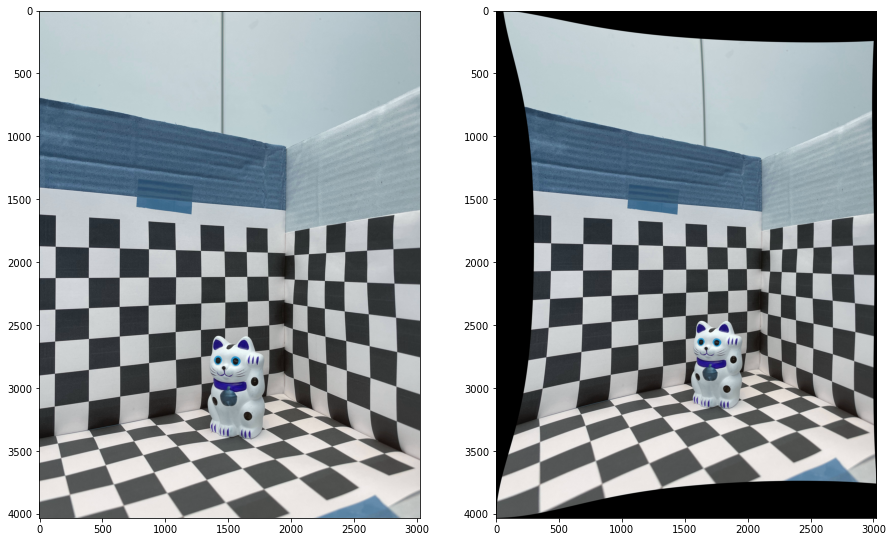

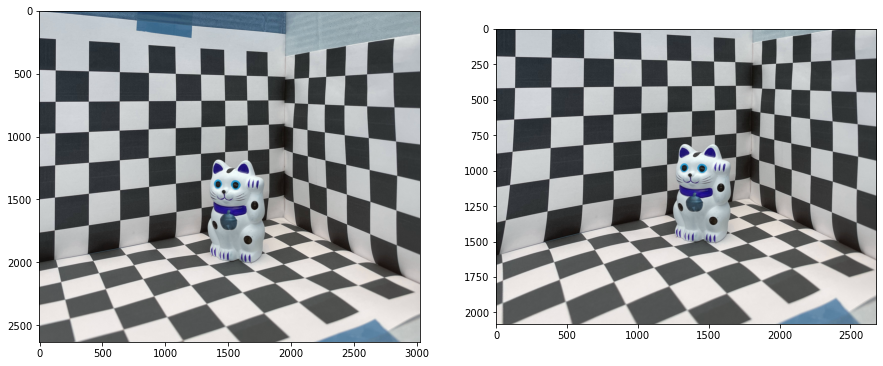

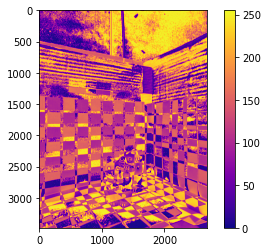

In [127]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img)
axes[1].imshow(dst)
dst = dst[y:y+h, x:x+w]
imgn = img[y:y+h, x:x+w]
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img[1400:, :])
axes[1].imshow(dst[1400:, :])
plt.savefig("undistorted_images.png")
plt.show()
diff = cv.cvtColor(imgn, cv.COLOR_BGR2GRAY) - cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
plt.imshow(diff, cmap='plasma')
plt.colorbar()

### Transformation estimation
- Estimate a homography matrix between a pair of images from HG.
    - Show the keypoints and their correspondences projected from the other image.
- Estimate fundamental matrix between a pair of images from FD.
    - Show the keypoints and their corresponding epipolar lines in the other image.
    - Show epipoles, vanishing points and horizon in your images.
- find out how many outliers the estimation method tolerates

#### Homography matrix

In [18]:
img1 = cv.imread(os.path.join("photos", "hg1.jpg"))
img2 = cv.imread(os.path.join("photos", "hg2.jpg"))

In [19]:
def homography(_img1, _img2, ratio):
    img1, kp1, img2, kp2, good = sift_match(_img1.copy(), _img2.copy(), ratio = ratio)
    matches_sift = matches_to_arr(kp1, kp2, good)

    left_keypoints = matches_sift[:,0,:]
    right_keypoints = matches_sift[:,1,:]
    
    print(f"Found {len(left_keypoints)} matches")

    ones = np.ones((left_keypoints.shape[0], 1))
    homog_left_keypoints = np.concatenate([left_keypoints, ones], axis=-1)
    
    draw_matches(img1[...,::-1], kp1, img2[...,::-1], kp2, good)

    M, _ = cv.findHomography(left_keypoints, right_keypoints, cv.RANSAC, 5.0)
    
    print("H = ")
    rows = [r for r in M]
    for r in rows:
        print(" ".join(['{0:.4f}'.format(x) for x in r]))
        
    transformed_left_keypoints = np.array([M @ x for x in homog_left_keypoints])
    z =  transformed_left_keypoints[:, -1]
    transformed_left_keypoints = np.array([transformed_left_keypoints[i] / z[i] for i in range(len(z))])[:, :-1]
    
    plt.figure(figsize=(7,7))
    plt.imshow(img2[...,::-1])
    for i in range(len(right_keypoints)):
        plt.plot(right_keypoints[i][0], right_keypoints[i][1], 'bo', markersize=5)
        plt.plot(transformed_left_keypoints[i][0], transformed_left_keypoints[i][1], 'r+', markersize=5)
    plt.xlim([0, img1.shape[1]])
    plt.ylim([img1.shape[0], 0])
    plt.legend(["Ground truth", "Projected keypoints from other image"])
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()
    
    err = 0
    n = 0

    for i in range(len(right_keypoints)):
        diff = (right_keypoints[i] - transformed_left_keypoints[i])**2
        err += diff[0] + diff[1]
        n += 2

    rmse = np.sqrt(err/n)

    print(f"RMSE = {round((rmse) * 10000)/10000}")  # Root mean square error between ground truth and projected point

Found 21 matches


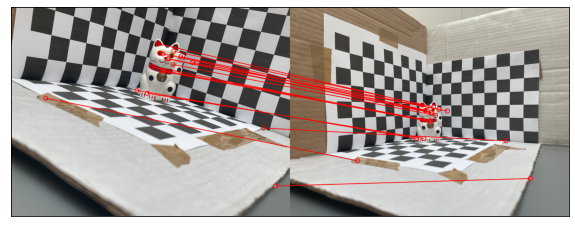

H = 
0.6258 0.0643 511.3599
-0.1670 0.5267 1467.3529
0.0000 -0.0001 1.0000


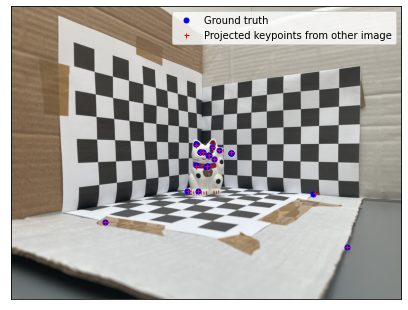

RMSE = 4.8234


In [20]:
homography(img1, img2, 0.20)

Found 159 matches


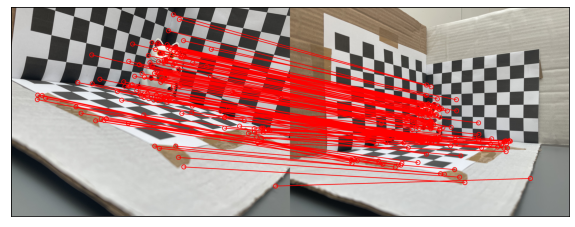

H = 
0.7532 0.0956 374.3399
-0.1127 0.5964 1423.9551
0.0000 -0.0000 1.0000


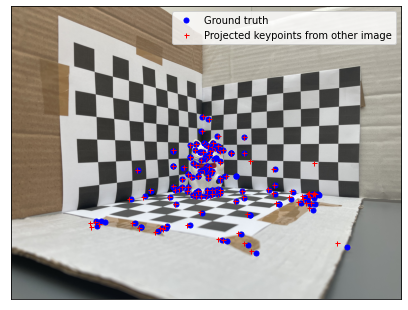

RMSE = 65.6869


In [21]:
homography(img1, img2, 0.4)

#### Fundamental matrix

In [22]:
img1 = cv.imread(os.path.join("photos", "img5.jpg"))
img2 = cv.imread(os.path.join("photos", "img6.jpg"))

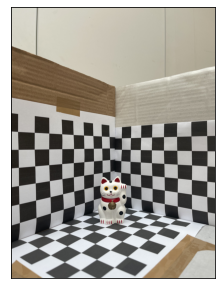

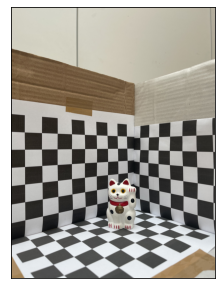

In [23]:
plt.figure(figsize=(5,5))
plt.imshow(img1[...,::-1])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.figure(figsize=(5,5))
plt.imshow(img2[...,::-1])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [24]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    pts1 = pts1.astype(int)
    pts2 = pts2.astype(int)
    r,c, _ = img1.shape
    plt.figure(figsize=(10,10))
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,20)
        img1 = cv.circle(img1,tuple(pt1),30,color,-1)
        img2 = cv.circle(img2,tuple(pt2),30,color,-1)
    return img1,img2

In [25]:
def fundamental(_img1, _img2, ratio):
    
    img1, kp1, img2, kp2, good = sift_match(_img1.copy(), _img2.copy(), ratio)
    matches_sift = matches_to_arr(kp1, kp2, good)

    left_keypoints = matches_sift[:,0,:]
    right_keypoints = matches_sift[:,1,:]    
    
    print(f"Found {len(left_keypoints)} matches")

    draw_matches(img1[...,::-1], kp1, img2[...,::-1], kp2, good)
    
    F, mask = cv.findFundamentalMat(left_keypoints, right_keypoints, cv.FM_LMEDS)
    
    print("F = ")
    rows = [r for r in F]
    for r in rows:
        print(" ".join(['{0:.4f}'.format(x) for x in r]))
        
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv.computeCorrespondEpilines(right_keypoints.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,left_keypoints,right_keypoints)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv.computeCorrespondEpilines(left_keypoints.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,right_keypoints,left_keypoints)
    plt.subplot(121)
    plt.imshow(img5[...,::-1])
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    
    plt.subplot(122)
    plt.imshow(img3[...,::-1])
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()
    
    # Checking that x'Fx = 0

    one = np.array([1])
    res = 0
    for i in range(len(right_keypoints)):
        res += np.concatenate([right_keypoints[i], one]) @ F @ np.concatenate([left_keypoints[i], one])
    
    accuracy = res/len(right_keypoints)
    print(f"Average value of x'Fx = {res/len(right_keypoints)}") # If this number is very low this means F is correct

    return F, accuracy, kp1, kp2, matches_sift

Found 8 matches


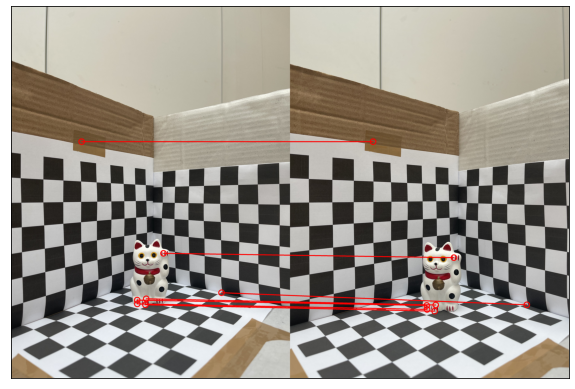

F = 
0.0000 0.0000 -0.0050
-0.0000 -0.0000 0.0015
0.0045 -0.0018 1.0000


<Figure size 720x720 with 0 Axes>

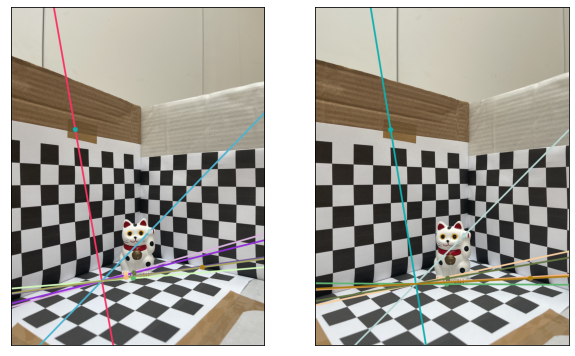

Average value of x'Fx = 5.551115123125783e-17


In [27]:
F, acc, _, _, _ = fundamental(img1, img2, 0.24)

Found 70 matches


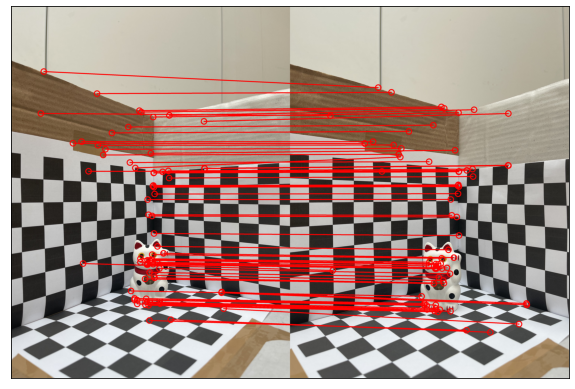

F = 
0.0000 -0.0000 0.0014
0.0000 -0.0000 -0.0128
-0.0031 0.0123 1.0000


<Figure size 720x720 with 0 Axes>

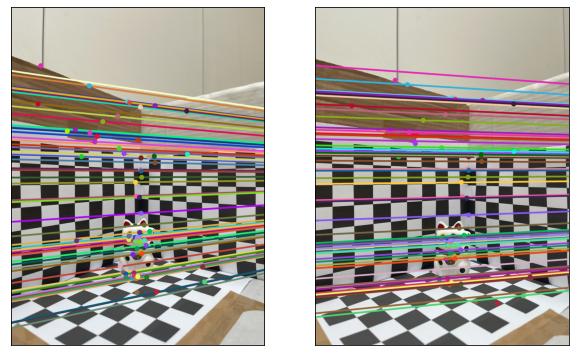

Average value of x'Fx = -0.028627182368785257


In [28]:
F, acc, _, _, _ = fundamental(img1, img2, 0.4)

### 3D geometry
- Show a stereo rectified pair of your images with epipolar lines.
- Calculate and display depth map of your object estimated from different views.

#### Stereo Rectification

Found 26 matches


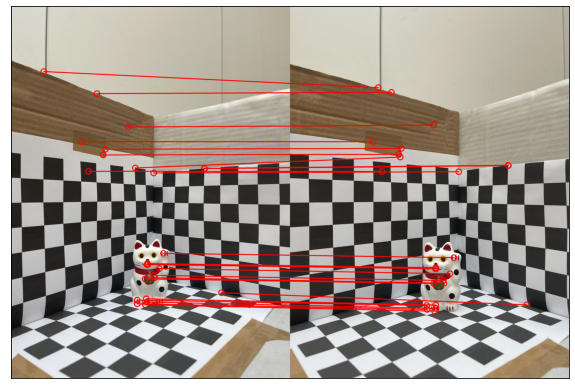

F = 
-0.0000 -0.0000 0.0083
0.0000 -0.0000 -0.0377
-0.0128 0.0374 1.0000


<Figure size 720x720 with 0 Axes>

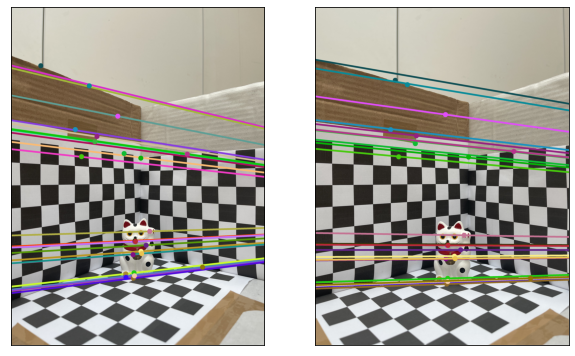

Average value of x'Fx = -0.043319324690674815


In [114]:
F, acc, kp1, kp2, matches = fundamental(img1, img2, 0.32)

In [116]:
h1, w1, z1 = img1.shape
h2, w2, z1 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(matches[:,0], matches[:,1], F, imgSize=(w1, h1))
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

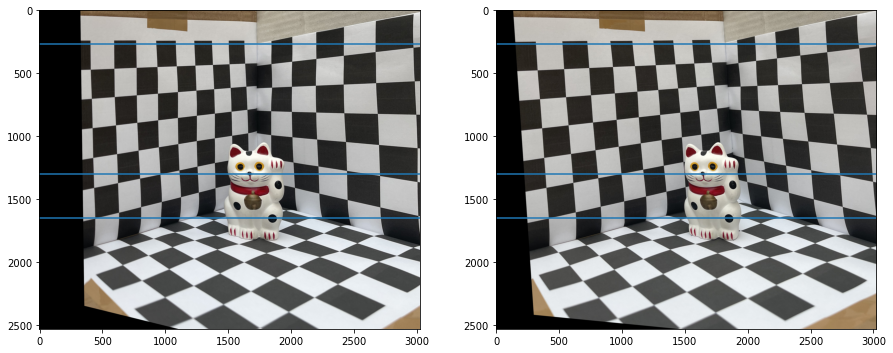

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
img1_rectified = img1_rectified[1500:,:]
img2_rectified = img2_rectified[1500:,:]
axes[0].imshow(img1_rectified[...,::-1])
axes[1].imshow(img2_rectified[...,::-1])
axes[0].axhline(1770-1500)
axes[1].axhline(1770-1500)
axes[0].axhline(2800-1500)
axes[1].axhline(2800-1500)
axes[0].axhline(3150-1500)
axes[1].axhline(3150-1500)
plt.savefig("rectified_images.png")
plt.show()

#### Depth Map

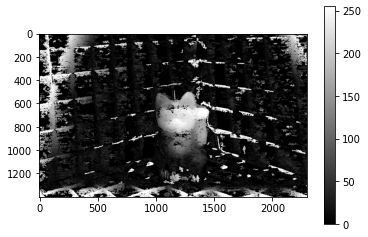

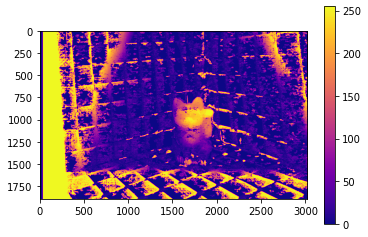

In [124]:
imgL = cv.imread('rectified_1.png',0)
imgR = cv.imread('rectified_2.png',0)
block_size = 3
num_disp = 32
uniquenessRatio = 5
speckleWindowSize = 200
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    #minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    #disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity = stereo.compute(imgL[1800:3700, :],imgR[1800:3700, :])
disparity = cv.normalize(disparity, disparity, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
plt.imshow(disparity[250:1650,500:2800],'gray')
plt.colorbar()
plt.show()
cv.imwrite("disparity.png", disparity)
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.show()